This notebook allows for the visualization of training metrics, reconstruction quality and latent space embeddings for some pre-trained models.

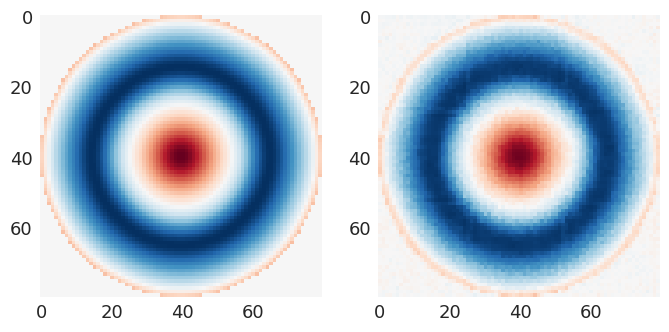

In [ ]:
import os
import yaml
from models.lit_model import LitModel, DataModule
from plot import plot_recon

version = 2
path = f"lightning_logs/version_{version}/"

with open(os.path.join(path, "hparams.yaml")) as f:
    hparams = yaml.safe_load(f)

ckpt = [f for f in os.listdir(path) if f.endswith(".ckpt")][1]

litmodel = LitModel.load_from_checkpoint(
    checkpoint_path=os.path.join(path, ckpt), config=hparams["config"]
)

data_module = DataModule(batch_size=64, num_workers=2)
data_module.setup()
test_set = data_module.test_data
model = litmodel.model
model.eval()

plot_recon(model, test_set)


Auto Encoder Reconstruction

In [15]:
from plot import training_log

training_log(version=[2, 4])

In [1]:
%matplotlib inline
from sklearn.cluster import DBSCAN
import numpy as np
import os
import torch
from plot import plot_class

latent_space = torch.load(
    os.path.join("lightning_logs/version_2/latent_space_per_epoch/199.pth")
)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(latent_space)

plot_class(clusters)

FigureWidget({
    'data': [{'customdata': [data/field_images/0.png, data/field_images/2.png,
                             data/field_images/3.png, ...,
                             data/field_images/3006.png,
                             data/field_images/3007.png,
                             data/field_images/3009.png],
              'hovertemplate': 'H: %{x}<br>E: %{y}<extra></extra>',
              'marker': {'color': '#2E91E5', 'size': 11},
              'mode': 'markers',
              'name': 'Class 0',
              'type': 'scatter',
              'uid': 'c143ba2d-9b77-4abd-a9d8-23cef79f2860',
              'x': [0.5238139349280231, 0.5238139349280231, 0.5238139349280231,
                    ..., 0.5785806608969681, 0.5785806608969681,
                    0.5785806608969681],
              'y': [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]},
             {'customdata': [data/field_images/1.png, data/field_images/15.png,
                             data/field_images/26.png, ...,
      

Clustering results: DBSCAN with eps=0.5, min_samples=5 gives 10 clusters with some noise points (-1).

In [5]:
from cluster_acc import purity, adj_rand_index

print("Purity: ", purity(clusters))
print("Adjusted Rand Index: ", adj_rand_index(clusters))

Purity:  0.9953488372093023
Adjusted Rand Index:  0.9985908959894364


/u/sasit/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:829: UserWarning:

Can't initialize NVML



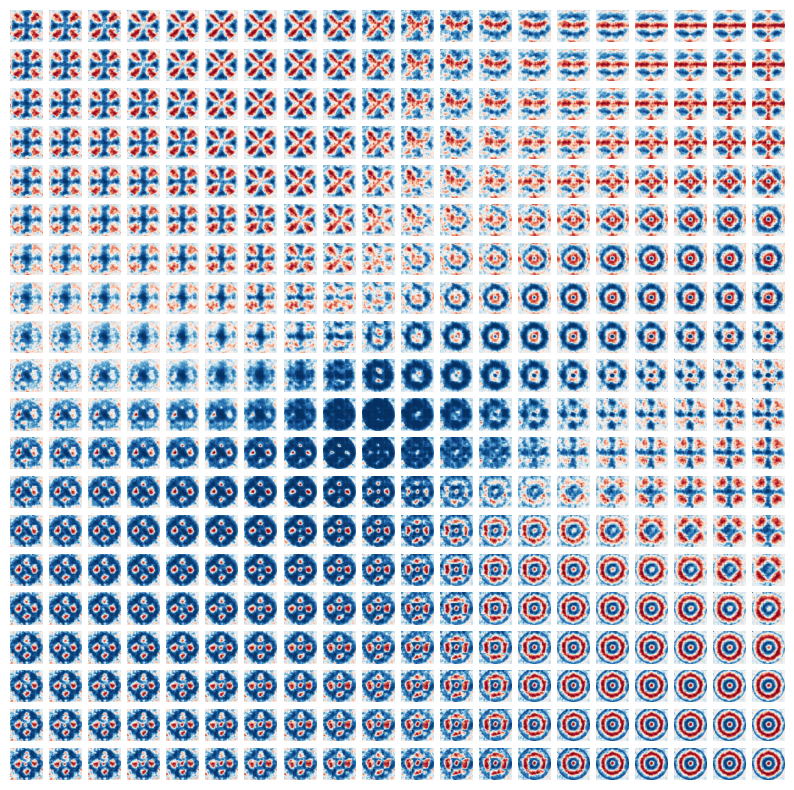

In [11]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from models.lit_model import LitModel, DataModule
from plot import plot_recon
import torch

version = 2
path = f"lightning_logs/version_{version}/"

with open(os.path.join(path, "hparams.yaml")) as f:
    hparams = yaml.safe_load(f)

ckpt = [f for f in os.listdir(path) if f.endswith(".ckpt")][1]

litmodel = LitModel.load_from_checkpoint(
    checkpoint_path=os.path.join(path, ckpt),
    config=hparams["config"]
)

data_module = DataModule(batch_size=64, num_workers=2)
data_module.setup()

latent_space = litmodel.model.encoder(data_module.data)


# generate a grid of points in the latent space
import numpy as np

n_points = 20
grid = np.array(
    np.meshgrid(np.linspace(-20, 20, n_points), np.linspace(-20, 20, n_points))
).T.reshape(-1, 2)

# convert to tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# decode the grid points
with torch.no_grad():
    decoded_points = litmodel.model.decoder(grid_tensor).numpy()

fig, ax = plt.subplots(n_points, n_points, figsize=(10, 10))
for i in range(n_points):
    for j in range(n_points):
        idx = i * n_points + j
        point = decoded_points[idx].reshape(
            decoded_points.shape[2], decoded_points.shape[3], decoded_points.shape[1]
        )
        ax[i, j].imshow(point[..., 2], vmin=-1, vmax=1, cmap="RdBu")
        ax[i, j].axis("off")
plt.show()




/u/sasit/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:829: UserWarning:

Can't initialize NVML



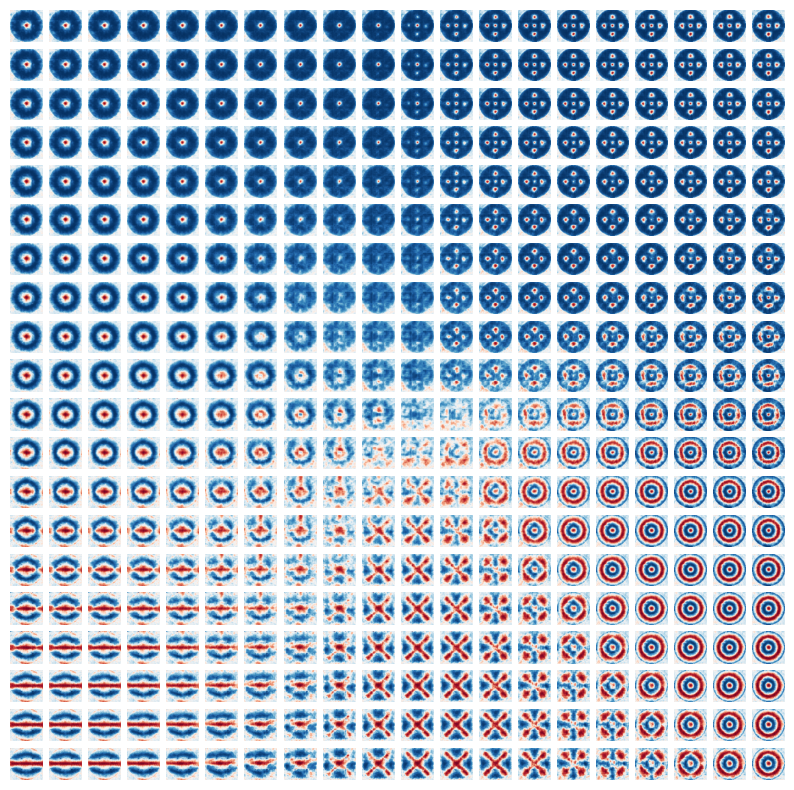

In [16]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from models.lit_model import LitModel, DataModule
from plot import plot_recon
import torch

version = 6
path = f"lightning_logs/version_{version}/"

with open(os.path.join(path, "hparams.yaml")) as f:
    hparams = yaml.safe_load(f)

ckpt = [f for f in os.listdir(path) if f.endswith(".ckpt")][1]

litmodel = LitModel.load_from_checkpoint(
    checkpoint_path=os.path.join(path, ckpt),
    config=hparams["config"]
)

data_module = DataModule(batch_size=64, num_workers=2)
data_module.setup()

latent_space = litmodel.model.latent_space(data_module.data)


# generate a grid of points in the latent space
import numpy as np

n_points = 20
grid = np.array(
    np.meshgrid(np.linspace(-20, 20, n_points), np.linspace(-20, 20, n_points))
).T.reshape(-1, 2)

# convert to tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# decode the grid points
with torch.no_grad():
    decoded_points = litmodel.model.decoder(grid_tensor).numpy()

fig, ax = plt.subplots(n_points, n_points, figsize=(10, 10))
for i in range(n_points):
    for j in range(n_points):
        idx = i * n_points + j
        point = decoded_points[idx].reshape(
            decoded_points.shape[2], decoded_points.shape[3], decoded_points.shape[1]
        )
        ax[i, j].imshow(point[..., 2], vmin=-1, vmax=1, cmap="RdBu")
        ax[i, j].axis("off")
plt.show()




In [ ]:
import imageio
import matplotlib.pyplot as plt
import torch
import pathlib as pl
import io
from PIL import Image
import numpy as np

max_val = 20  # set the same max_val as before


def fig_to_array(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    img = Image.open(buf)
    arr = np.array(img)
    buf.close()
    return arr


def latent_gif(data_path, filename):
    """
    Create a GIF of the latent space over epochs.
    """
    # sort the files by epoch number
    tensor_files = sorted(pl.Path(data_path).glob("*.pth"), key=lambda x: int(x.stem))
    images = []
    for f in tensor_files:
        z = torch.load(f)
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(z[:, 0], z[:, 1], cmap="viridis")
        plt.colorbar(scatter)
        plt.title(f"Latent Space - Epoch {f.stem}")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.xlim(-max_val, max_val)
        plt.ylim(-max_val, max_val)
        plt.tight_layout()
        images.append(fig_to_array(fig))
        plt.close()
    imageio.mimsave(f"{filename}.gif", images, fps=10)


latent_gif(
    "lightning_logs/version_6/latent_space_per_epoch", "latent_space_variational"
)

/tmp/ipykernel_8438/2648806612.py:30: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

